## FFT

A fast algorithm to calculate the DFT

$$
X[k] = \sum_{n=0}^{N-1}x[n]e^{-j2\pi kn/N}
$$
$$
x[n] = \frac{1}{2\pi}\sum_{k=0}^{N-1}X[k]e^{j2\pi kn/N}
$$

(1000,)


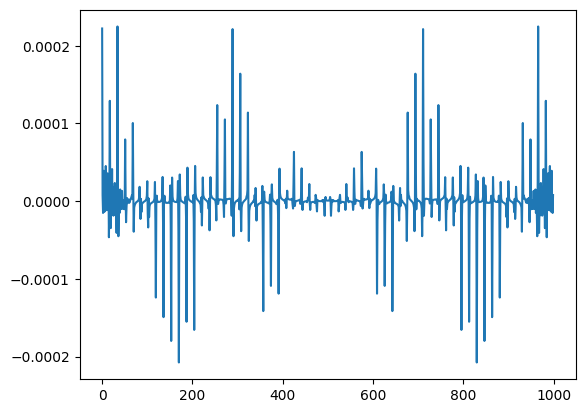

In [28]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.fft import fft,ifft

signal = np.load("../data/sim_100_0.1_90_140_train.npy")[1,:1000]

f = fft(signal)
print(f.shape)
plt.plot(f)
plt.show()

## Analytic Signal and Hilbert Transformation

Fourier Transform of a real-valued signal is complex-symmetric whose negative frequencies are redundant with respect to the positive frequencies. To remove the redundancy, the analytic signal is invented. It is complex-valued but its spectrum will be one-sided (only positive frequencies) that preserved the spectral content of the original real-valued signal. Using an analytic signal instead of the original real-valued signal, is useful in many signal processing applications. For example, in spectral analysis, use of analytic signal in-lieu of the original real-valued signal mitigates estimation biases and eliminates cross-term artifacts due to negative and positive frequency components.

In the frequency domain, the analytic signal has only the postive part of the original signal and the magnitude is two times of the orignal postive spectrum. In the time domain, the real part of the analytic signal is the same as the original signal, but it has a imaginary part. $z(t)$ denotes the time domain analytic singal, and $x(t)$ denotes the original signal.
$$
z(t) = z_{r}(t) + z_{i}(t) = x(t) + z_{i}(t)
$$
So what's the imaginary part? Hilbert Transformation can be used to find the imaginary part of the orignal real-valude signal.
$$
z(t) = z_{r}(t) + z_{i}(t) = x(t) + jHT\{x(t)\}
$$
$$
HT\{x(t)\} = x(t) * \frac{1}{\pi t} \longleftrightarrow F(f)[-jsgn(f)] = \begin{cases}-jF(f) & f > 0 \\ jF(f) & f< 0 \end{cases}
$$
We can take the hilbert transformation as a filter whose impulse response is $\frac{1}{\pi t}$. And the HT\{x(t)\} has some properties.
1. HT\{HT\{x(t)\}\} = -x(t)
2. HT\{x(t)\} has the opposite parity of x(t)
3. HT\{x(t)\} and x(t) are orthogonal

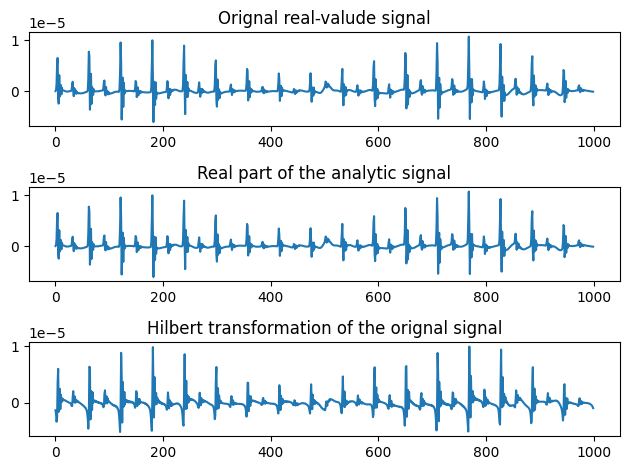

In [27]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.fft import fft,ifft

def analytic_signal(x):
    N = len(x)
    X = fft(x,N)
    h = np.zeros(N)
    h[0] = 1
    h[1:N//2] = 2*np.ones(N//2-1)
    h[N//2] = 1
    Z = X*h
    z = ifft(Z,N)
    return z

def hilbert_transform(x):
    z = analytic_signal(x)
    return z.imag

signal = np.load("../data/sim_100_0.1_90_140_train.npy")[1,:1000]
z = analytic_signal(signal)

fig, axis = plt.subplots(3,1)
axis[0].set_title("Orignal real-valude signal")
axis[0].plot(signal)

axis[1].set_title("Real part of the analytic signal")
axis[1].plot(z.real)

axis[2].set_title("Hilbert transformation of the orignal signal")
axis[2].plot(hilbert_transform(signal))
plt.tight_layout()
plt.show()